In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import sys #access to system parameters https://docs.python.org/3/library/sys.html
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv). Collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import matplotlib #collection of functions for scientific and publication-ready visualization
import scipy as sp #collection of functions for scientific computing and advanced mathematics
import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
import sklearn #collection of machine learning algorithms
import graphviz 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import random, time
#import time
import warnings
warnings.filterwarnings('ignore')
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'test.csv', 'gender_submission.csv']


In [2]:
#Common model algos
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

In [3]:
#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection, model_selection, metrics

In [4]:
#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

In [5]:
#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline 
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [6]:
raw_data = pd.read_csv('../input/train.csv')

In [7]:
test_data = pd.read_csv('../input/test.csv')

In [8]:
temp_data = raw_data.copy(deep = True)

In [9]:
clean_data = [temp_data, test_data]

**Clean Data**

In [10]:
for dataset in clean_data:
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)

In [11]:
drop_column = ['PassengerId', 'Cabin', 'Ticket']
temp_data.drop(drop_column, axis=1,inplace=True)

**Feature Engineering**

Consider creating new features that separate family size as purely binary values instead of whole numbers.

In [27]:
for dataset in clean_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    dataset['FareBin'] = pd.qcut(dataset['Fare'],4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int),5)
    stat_min = 10
    title_names = (dataset['Title'].value_counts() < stat_min)
    dataset['Title'] = dataset['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

In [ ]:
#stat_min = 10
#title_names = (temp_data['Title'].value_counts() < stat_min)
#temp_data['Title'] = temp_data['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

In [28]:
temp_data['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64

In [29]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
PassengerId      418 non-null int64
Pclass           418 non-null int64
Name             418 non-null object
Sex              418 non-null object
Age              418 non-null float64
SibSp            418 non-null int64
Parch            418 non-null int64
Ticket           418 non-null object
Fare             418 non-null float64
Cabin            91 non-null object
Embarked         418 non-null object
FamilySize       418 non-null int64
IsAlone          418 non-null int64
Title            418 non-null object
FareBin          418 non-null category
AgeBin           418 non-null category
Sex_Code         418 non-null int64
Embarked_Code    418 non-null int64
Title_Code       418 non-null int64
AgeBin_Code      418 non-null int64
FareBin_Code     418 non-null int64
dtypes: category(2), float64(2), int64(11), object(6)
memory usage: 63.1+ KB


In [30]:
label = LabelEncoder()
#print(label)

In [31]:
temp_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,2,3,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,0,4,2,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]",0,2,2,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,2,4,2,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]",1,2,3,2,1
5,0,3,"Moran, Mr. James",male,28.0,0,0,8.4583,Q,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]",1,1,3,1,1
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,S,1,1,Mr,"(31.0, 512.329]","(48.0, 64.0]",1,2,3,3,3
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,S,5,0,Master,"(14.454, 31.0]","(-0.08, 16.0]",1,2,0,0,2
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S,3,0,Mrs,"(7.91, 14.454]","(16.0, 32.0]",0,2,4,1,1
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,C,2,0,Mrs,"(14.454, 31.0]","(-0.08, 16.0]",0,0,4,0,2


In [32]:
print(temp_data['FareBin'].value_counts())
print(temp_data['AgeBin'].value_counts())
print(temp_data['IsAlone'].value_counts())
print(temp_data['Title'].value_counts())

(7.91, 14.454]     224
(-0.001, 7.91]     223
(31.0, 512.329]    222
(14.454, 31.0]     222
Name: FareBin, dtype: int64
(16.0, 32.0]     525
(32.0, 48.0]     186
(-0.08, 16.0]    100
(48.0, 64.0]      69
(64.0, 80.0]      11
Name: AgeBin, dtype: int64
1    537
0    354
Name: IsAlone, dtype: int64
Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64


In [33]:
for dataset in clean_data:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin']) 

In [34]:
Target = ['Survived']

In [39]:
print(test_data['AgeBin_Code'].value_counts())
print(test_data['AgeBin'].value_counts())
print(temp_data['AgeBin_Code'].value_counts())
print(temp_data['AgeBin'].value_counts())

1    254
2     80
3     42
0     32
4     10
Name: AgeBin_Code, dtype: int64
(15.2, 30.4]      254
(30.4, 45.6]       80
(45.6, 60.8]       42
(-0.076, 15.2]     32
(60.8, 76.0]       10
Name: AgeBin, dtype: int64
1    525
2    186
0    100
3     69
4     11
Name: AgeBin_Code, dtype: int64
(16.0, 32.0]     525
(32.0, 48.0]     186
(-0.08, 16.0]    100
(48.0, 64.0]      69
(64.0, 80.0]      11
Name: AgeBin, dtype: int64


In [40]:
target_title = temp_data[temp_data['Survived'] == 1]['Title_Code'].value_counts()/temp_data['Title_Code'].value_counts()
target_sex = temp_data[temp_data['Survived'] == 1]['Sex_Code'].value_counts()/temp_data['Sex_Code'].value_counts()
target_age = temp_data[temp_data['Survived'] == 1]['AgeBin_Code'].value_counts()/temp_data['AgeBin_Code'].value_counts()
target_fare = temp_data[temp_data['Survived'] == 1]['FareBin_Code'].value_counts()/temp_data['FareBin_Code'].value_counts()
target_embarked = temp_data[temp_data['Survived'] == 1]['Embarked_Code'].value_counts()/temp_data['Embarked_Code'].value_counts()
target_pclass = temp_data[temp_data['Survived'] == 1]['Pclass'].value_counts()/temp_data['Pclass'].value_counts()
target_family = temp_data[temp_data['Survived'] == 1]['FamilySize'].value_counts()/temp_data['FamilySize'].value_counts()
target_family = target_family.fillna(0)

print(target_title,'\n',target_age,'\n',target_embarked,'\n',target_fare,'\n',target_sex, '\n', target_pclass,'\n',target_family)

0    0.575000
1    0.444444
2    0.697802
3    0.156673
4    0.792000
Name: Title_Code, dtype: float64 
 1    0.344762
2    0.403226
0    0.550000
3    0.434783
4    0.090909
Name: AgeBin_Code, dtype: float64 
 2    0.339009
0    0.553571
1    0.389610
Name: Embarked_Code, dtype: float64 
 0    0.197309
1    0.303571
2    0.454955
3    0.581081
Name: FareBin_Code, dtype: float64 
 0    0.742038
1    0.188908
Name: Sex_Code, dtype: float64 
 1    0.629630
2    0.472826
3    0.242363
Name: Pclass, dtype: float64 
 1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: FamilySize, dtype: float64


In [41]:
for dataset in clean_data:
    title_list = target_title[dataset['Title_Code']]
    age_list = target_age[dataset['AgeBin_Code']]
    embarked_list = target_embarked[dataset['Embarked_Code']]
    fare_list = target_fare[dataset['FareBin_Code']]
    sex_list = target_sex[dataset['Sex_Code']]
    pclass_list = target_pclass[dataset['Pclass']]
    family_list = target_family[dataset['FamilySize']]
    
    Title_Target = []
    Age_Target = []
    Embarked_Target = []
    Fare_Target = []
    Sex_Target = []
    Pclass_Target = []
    Family_Target = []

    for title in title_list:
        Title_Target.append(title)
    for age in age_list:
        Age_Target.append(age)
    for embarked in embarked_list:
        Embarked_Target.append(embarked)
    for fare in fare_list:
        Fare_Target.append(fare)
    for sex in sex_list:
        Sex_Target.append(sex)
    for pclass in pclass_list:
        Pclass_Target.append(pclass)
    for family in family_list:
        Family_Target.append(family)

    dataset['Title_Target'] = Title_Target
    dataset['Age_Target'] = Age_Target
    dataset['Embarked_Target'] = Embarked_Target
    dataset['Fare_Target'] = Fare_Target
    dataset['Sex_Target'] = Sex_Target
    dataset['Pclass_Target'] = Pclass_Target
    dataset['Family_Target'] = Family_Target

In [101]:
print (temp_data['Title'].value_counts(),'\n', temp_data['Title_Target'].value_counts())

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64 
 0.156673    517
0.697802    182
0.792000    125
0.575000     40
0.444444     27
Name: Title_Target, dtype: int64


In [44]:
print (test_data.isna().sum())

PassengerId          0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              327
Embarked             0
FamilySize           0
IsAlone              0
Title                0
FareBin              0
AgeBin               0
Sex_Code             0
Embarked_Code        0
Title_Code           0
AgeBin_Code          0
FareBin_Code         0
Title_Target         0
Age_Target           0
Embarked_Target      0
Fare_Target          0
Sex_Target           0
Pclass_Target        0
Family_Target        0
dtype: int64


In [47]:
temp_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
temp_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare']
temp_xy = Target + temp_x
print('Original X Y: ', temp_xy,'\n')

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 



In [48]:
#temp_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
temp_x_bin = ['Sex_Target','Pclass_Target', 'Embarked_Target', 'Title_Target', 'Family_Target', 'Age_Target', 'Fare_Target']
temp_xy_bin = Target + temp_x_bin
print('Bin X Y: ', temp_xy_bin,'\n')

Bin X Y:  ['Survived', 'Sex_Target', 'Pclass_Target', 'Embarked_Target', 'Title_Target', 'Family_Target', 'Age_Target', 'Fare_Target'] 



In [49]:
temp_data[temp_xy]

,Survived,Sex,Pclass,Embarked,Title,SibSp,Parch,Age,Fare,FamilySize,IsAlone
0,0,male,3,S,Mr,1,0,22.0,7.2500,2,0
1,1,female,1,C,Mrs,1,0,38.0,71.2833,2,0
2,1,female,3,S,Miss,0,0,26.0,7.9250,1,1
3,1,female,1,S,Mrs,1,0,35.0,53.1000,2,0
4,0,male,3,S,Mr,0,0,35.0,8.0500,1,1
5,0,male,3,Q,Mr,0,0,28.0,8.4583,1,1
6,0,male,1,S,Mr,0,0,54.0,51.8625,1,1
7,0,male,3,S,Master,3,1,2.0,21.0750,5,0
8,1,female,3,S,Mrs,0,2,27.0,11.1333,3,0
9,1,female,2,C,Mrs,1,0,14.0,30.0708,2,0


In [99]:
print (target_title, '\n',test_data[['Title_Target', 'Title']])

0    0.575000
1    0.444444
2    0.697802
3    0.156673
4    0.792000
Name: Title_Code, dtype: float64 
      Title_Target   Title
0        0.156673      Mr
1        0.792000     Mrs
2        0.156673      Mr
3        0.156673      Mr
4        0.792000     Mrs
5        0.156673      Mr
6        0.697802    Miss
7        0.156673      Mr
8        0.792000     Mrs
9        0.156673      Mr
10       0.156673      Mr
11       0.156673      Mr
12       0.792000     Mrs
13       0.156673      Mr
14       0.792000     Mrs
15       0.792000     Mrs
16       0.156673      Mr
17       0.156673      Mr
18       0.697802    Miss
19       0.792000     Mrs
20       0.156673      Mr
21       0.575000  Master
22       0.792000     Mrs
23       0.156673      Mr
24       0.792000     Mrs
25       0.156673      Mr
26       0.697802    Miss
27       0.156673      Mr
28       0.156673      Mr
29       0.156673      Mr
..            ...     ...
388      0.156673      Mr
389      0.575000  Master
390      0.

In [51]:
temp_data[temp_x_bin]

,Sex_Target,Pclass_Target,Embarked_Target,Title_Target,Family_Target,Age_Target,Fare_Target
0,0.188908,0.242363,0.339009,0.156673,0.552795,0.344762,0.197309
1,0.742038,0.629630,0.553571,0.792000,0.552795,0.403226,0.581081
2,0.742038,0.242363,0.339009,0.697802,0.303538,0.344762,0.303571
3,0.742038,0.629630,0.339009,0.792000,0.552795,0.403226,0.581081
4,0.188908,0.242363,0.339009,0.156673,0.303538,0.403226,0.303571
5,0.188908,0.242363,0.389610,0.156673,0.303538,0.344762,0.303571
6,0.188908,0.629630,0.339009,0.156673,0.303538,0.434783,0.581081
7,0.188908,0.242363,0.339009,0.575000,0.200000,0.550000,0.454955
8,0.742038,0.242363,0.339009,0.792000,0.578431,0.344762,0.303571
9,0.742038,0.472826,0.553571,0.792000,0.552795,0.550000,0.454955


In [52]:
temp_dummy = pd.get_dummies(temp_data[temp_x])
temp_x_dummy = temp_dummy.columns.tolist()
temp_xy_dummy = Target + temp_x_dummy
print('Dummy X Y: ', temp_xy_dummy, '\n')

temp_dummy.head()

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [53]:
print (temp_data.isna().sum())
print ('--'*20)
print (test_data.isna().sum())
print ('--'*20)

Survived           0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Fare               0
Embarked           0
FamilySize         0
IsAlone            0
Title              0
FareBin            0
AgeBin             0
Sex_Code           0
Embarked_Code      0
Title_Code         0
AgeBin_Code        0
FareBin_Code       0
Title_Target       0
Age_Target         0
Embarked_Target    0
Fare_Target        0
Sex_Target         0
Pclass_Target      0
Family_Target      0
dtype: int64
----------------------------------------
PassengerId          0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              327
Embarked             0
FamilySize           0
IsAlone              0
Title                0
FareBin              0
AgeBin               0
Sex_Code             0
Embarked_

In [54]:
raw_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Fynney, Mr. Joseph J",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [55]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(temp_data[temp_x_calc], temp_data[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(temp_data[temp_x_bin], temp_data[Target], random_state = 0)
train1_x_dummy, test1_x_dummy, train_y_dummy, test_y_dummy = model_selection.train_test_split(temp_dummy[temp_x_dummy], temp_data[Target], random_state = 0)

print("Temp Shape: {}".format(temp_data.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Temp Shape: (891, 26)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Target,Pclass_Target,Embarked_Target,Title_Target,Family_Target,Age_Target,Fare_Target
105,0.188908,0.242363,0.339009,0.156673,0.303538,0.344762,0.197309
68,0.742038,0.242363,0.339009,0.697802,0.333333,0.344762,0.303571
253,0.188908,0.242363,0.339009,0.156673,0.552795,0.344762,0.454955
320,0.188908,0.242363,0.339009,0.156673,0.303538,0.344762,0.197309
706,0.742038,0.472826,0.339009,0.792000,0.303538,0.403226,0.303571


**Done Cleaning!**

**Visualization**

In [56]:
for feature in temp_x:
    if temp_data[feature].dtype != 'float64':
        print ('Survival Correlation by: ',feature)
        print (temp_data[[feature, Target[0]]].groupby(feature, as_index=False).mean())
        print('--'*20, '\n')

Survival Correlation by:  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------------------------------------- 

Survival Correlation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------------------------------------- 

Survival Correlation by:  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------------------------------------- 

Survival Correlation by:  Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------------------------------------- 

Survival Correlation by:  SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------------------------------------- 

Survival Correlation by:  Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000


In [57]:
#using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
print(pd.crosstab(temp_data['Title'],temp_data[Target[0]]))

Survived    0    1
Title             
Master     17   23
Misc       15   12
Miss       55  127
Mr        436   81
Mrs        26   99


In [58]:
temp_data[temp_data['Survived'] == 1]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,...,Title_Code,AgeBin_Code,FareBin_Code,Title_Target,Age_Target,Embarked_Target,Fare_Target,Sex_Target,Pclass_Target,Family_Target
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,71.2833,C,2,...,4,2,3,0.792000,0.403226,0.553571,0.581081,0.742038,0.629630,0.552795
2,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,7.9250,S,1,...,2,1,1,0.697802,0.344762,0.339009,0.303571,0.742038,0.242363,0.303538
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,53.1000,S,2,...,4,2,3,0.792000,0.403226,0.339009,0.581081,0.742038,0.629630,0.552795
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,11.1333,S,3,...,4,1,1,0.792000,0.344762,0.339009,0.303571,0.742038,0.242363,0.578431
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,30.0708,C,2,...,4,0,2,0.792000,0.550000,0.553571,0.454955,0.742038,0.472826,0.552795
10,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.00,1,1,16.7000,S,3,...,2,0,2,0.697802,0.550000,0.339009,0.454955,0.742038,0.242363,0.578431
11,1,1,"Bonnell, Miss. Elizabeth",female,58.00,0,0,26.5500,S,1,...,2,3,2,0.697802,0.434783,0.339009,0.454955,0.742038,0.629630,0.303538
15,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.00,0,0,16.0000,S,1,...,4,3,2,0.792000,0.434783,0.339009,0.454955,0.742038,0.472826,0.303538
17,1,2,"Williams, Mr. Charles Eugene",male,28.00,0,0,13.0000,S,1,...,3,1,1,0.156673,0.344762,0.339009,0.303571,0.188908,0.472826,0.303538
19,1,3,"Masselmani, Mrs. Fatima",female,28.00,0,0,7.2250,C,1,...,4,1,0,0.792000,0.344762,0.553571,0.197309,0.742038,0.242363,0.303538


In [59]:
temp_data[temp_data['Survived']==1]['Title'].value_counts()/temp_data['Title'].value_counts() * 100

Master    57.500000
Misc      44.444444
Miss      69.780220
Mr        15.667311
Mrs       79.200000
Name: Title, dtype: float64

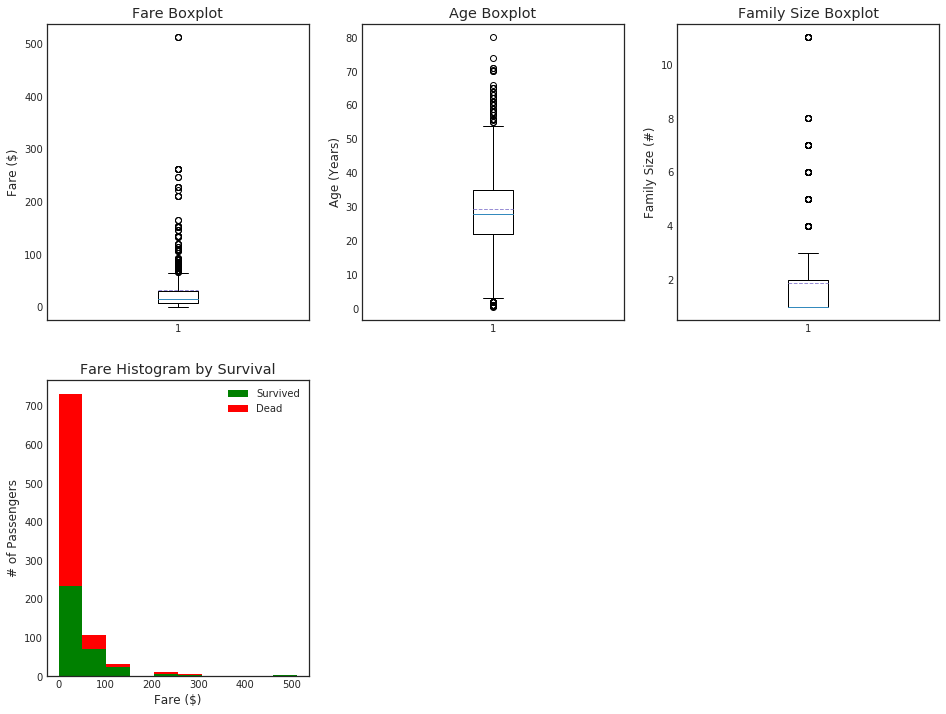

In [60]:
#plt.figure(figsize=[16,12])
plt.figure(figsize=[16,12])
#plt.subplot(231)
plt.subplot(231)
#plt.boxplot(x=data1['Fare'], showmeans = True, meanline = True)
plt.boxplot(x=temp_data['Fare'], showmeans=True, meanline=True)
#plt.title('Fare Boxplot')
plt.title('Fare Boxplot')
#plt.ylabel('Fare ($)')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(temp_data['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

#plt.subplot(233)
plt.subplot(233)
#plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.boxplot(temp_data['FamilySize'], showmeans=True, meanline=True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

#plt.subplot(234)
plt.subplot(234)
#plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
#         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.hist(x = [temp_data[temp_data['Survived']==1]['Fare'],temp_data[temp_data['Survived']==0]['Fare']],
        stacked=True, color =['g', 'r'], label=['Survived', 'Dead'])
#plt.title('Fare Histogram by Survival')
plt.title('Fare Histogram by Survival')
#plt.xlabel('Fare ($)')
plt.xlabel('Fare ($)')
#plt.ylabel('# of Passengers')
plt.ylabel('# of Passengers')
#plt.legend()
plt.legend()

#plt.subplot(235)
#plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
#         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
#plt.title('Age Histogram by Survival')
#plt.xlabel('Age (Years)')
#plt.ylabel('# of Passengers')
#plt.legend()

#plt.subplot(236)
#plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
#         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
#plt.title('Family Size Histogram by Survival')
#plt.xlabel('Family Size (#)')
#plt.ylabel('# of Passengers')
#plt.legend()

In [61]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

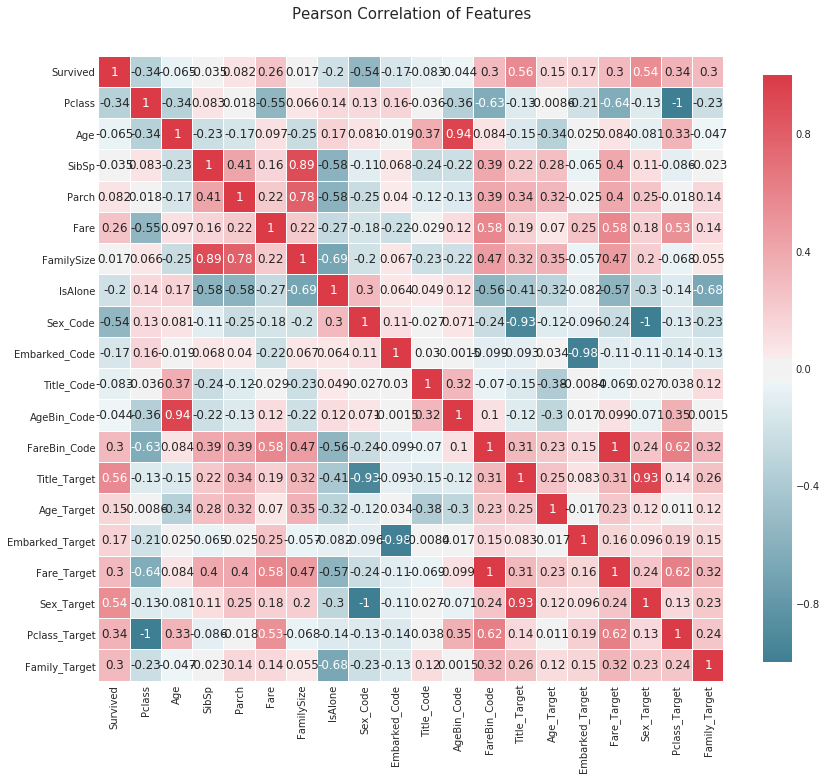

In [62]:
correlation_heatmap(temp_data)

**Implement Ensembling**

**Cross Validation**

In [63]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

In [64]:
cv_split = model_selection.ShuffleSplit(n_splits=5, random_state= 0, train_size=0.8)

In [65]:
MLA_columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy Mean', 'Test Accuracy 3*STD', 'Time']
MLA_compare = pd.DataFrame(columns=MLA_columns)

In [66]:
MLA_predict = temp_data[Target]

In [67]:
row_index = 0

In [68]:
#MLA_compare.columns
temp_x_bin

['Sex_Target',
 'Pclass_Target',
 'Embarked_Target',
 'Title_Target',
 'Family_Target',
 'Age_Target',
 'Fare_Target']

In [69]:
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'Name'] = MLA_name
    MLA_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    cv_results = model_selection.cross_validate(alg, temp_data[temp_x_bin], temp_data[Target], cv = cv_split)
    MLA_compare.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    alg.fit(temp_data[temp_x_bin], temp_data[Target])
    MLA_predict[MLA_name] = alg.predict(temp_data[temp_x_bin])    
    row_index+=1

In [70]:
MLA_compare.sort_values(by='Test Accuracy Mean', ascending=False, inplace = True)
MLA_compare

,Name,Parameters,Train Accuracy Mean,Test Accuracy Mean,Test Accuracy 3*STD,Time
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.825562,0.822222,0.10328,0.0922303
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.860955,0.817778,0.0541603,0.00202994
20,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.819101,0.815556,0.0979796,0.0548978
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.856742,0.813333,0.0928559,0.0647463
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.889045,0.811111,0.0365148,0.015106
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.850281,0.808889,0.10198,0.0238621
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.820506,0.802222,0.0879394,0.0826582
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.81573,0.802222,0.0489898,1.0178
8,RidgeClassifierCV,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': N...",0.816573,0.8,0.0918937,0.0112261
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.817978,0.8,0.0918937,0.00562673


Text(0,0.5,'Classifier')

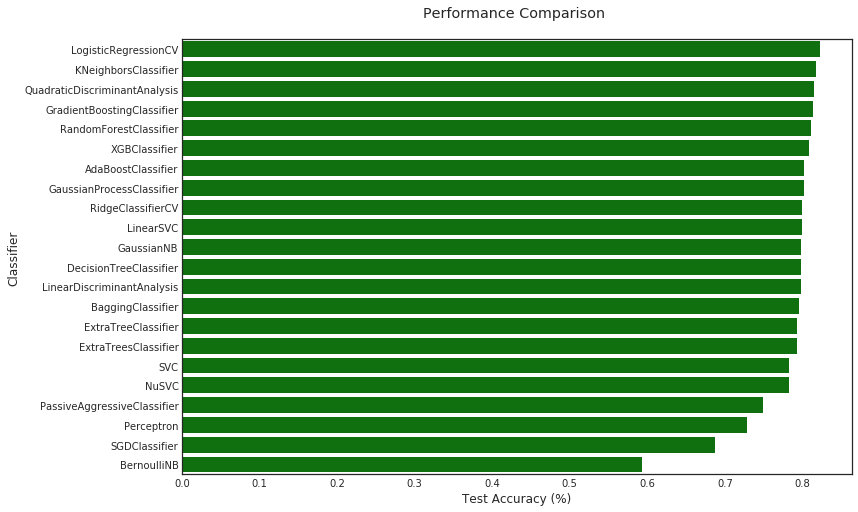

In [71]:
sns.barplot(x='Test Accuracy Mean', y='Name', data=MLA_compare, color = 'g')
plt.title('Performance Comparison \n')
plt.xlabel('Test Accuracy (%)')
plt.ylabel('Classifier')

**Implementation?**

In [72]:
#base model
dtree = tree.DecisionTreeClassifier(random_state=0)
base_results = model_selection.cross_validate(dtree, temp_data[temp_x_bin], temp_data[Target], cv = cv_split)
dtree.fit(temp_data[temp_x_bin], temp_data[Target])

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)


BEFORE DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 89.10
BEFORE DT Test w/bin score mean: 79.56
BEFORE DT Test w/bin score 3*std: +/- 5.81
----------


In [73]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              #'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,12,None], #max depth tree can grow; default is none
              #'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              #'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              #'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

#print(list(model_selection.ParameterGrid(param_grid)))

#tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
#tune_model.fit(data1[data1_x_bin], data1[Target])
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring ='roc_auc', cv=cv_split)
tune_model.fit(temp_data[temp_x_bin], temp_data[Target])

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size='default', train_size=0.8),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, 12, None], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [74]:
print ('Best estimator is: ',tune_model.best_estimator_, '\n Best score is: ', tune_model.best_score_)

Best estimator is:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best') 
 Best score is:  0.8816661574318664


In [75]:
print('AFTER DT Parameters: ', tune_model.best_params_)
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

AFTER DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Training w/bin score mean: 89.65
AFTER DT Test w/bin score mean: 88.17
AFTER DT Test w/bin score 3*std: +/- 12.10
----------


**Feature Selection**

In [76]:
dtree_rfe = feature_selection.RFECV(dtree, scoring='accuracy', cv=cv_split)
dtree_rfe.fit(temp_data[temp_x_bin], temp_data[Target])

X_rfe = temp_data[temp_x_bin].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, temp_data[X_rfe], temp_data[Target], cv = cv_split)

In [77]:
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
rfe_tune_model.fit(temp_data[X_rfe], temp_data[Target])

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size='default', train_size=0.8),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, 12, None], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [78]:
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

AFTER DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT RFE Tuned Training w/bin score mean: 89.50
AFTER DT RFE Tuned Test w/bin score mean: 87.19
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 9.93
----------


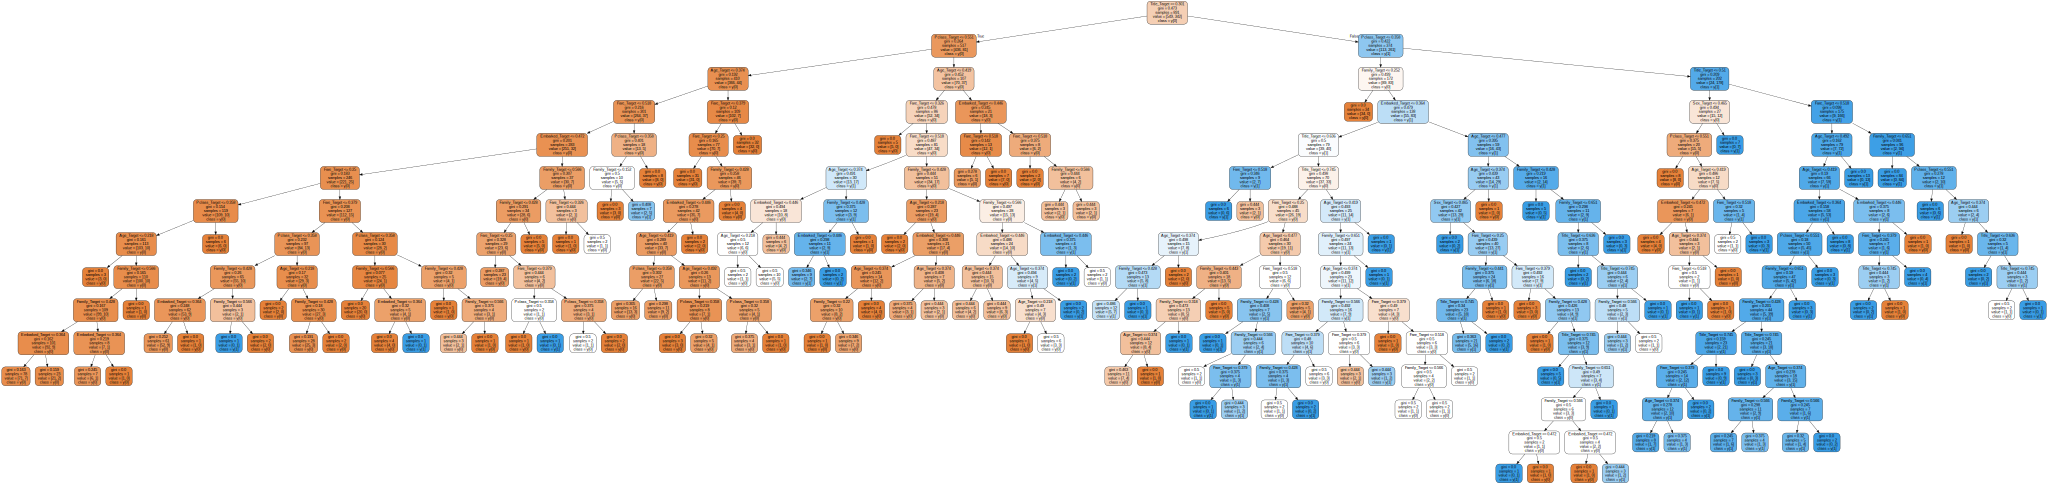

In [79]:
dot_data = tree.export_graphviz(dtree, out_file=None, 
                                feature_names = temp_x_bin, class_names = True,
                                filled = True, rounded = True)
graph = graphviz.Source(dot_data) 
graph

In [80]:
MLA_predict.describe()

,Survived,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier,GaussianProcessClassifier,LogisticRegressionCV,PassiveAggressiveClassifier,RidgeClassifierCV,...,GaussianNB,KNeighborsClassifier,SVC,NuSVC,LinearSVC,DecisionTreeClassifier,ExtraTreeClassifier,LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis,XGBClassifier
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.388328,0.349046,0.322110,0.305275,0.338945,0.356902,0.353535,0.991021,0.365881,...,0.407407,0.378227,0.352413,0.352413,0.363636,0.322110,0.322110,0.367003,0.399551,0.316498
std,0.486592,0.487644,0.476936,0.467547,0.460782,0.473617,0.479355,0.478336,0.094383,0.481947,...,0.491628,0.485217,0.477990,0.477990,0.481316,0.467547,0.467547,0.482258,0.490081,0.465371
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


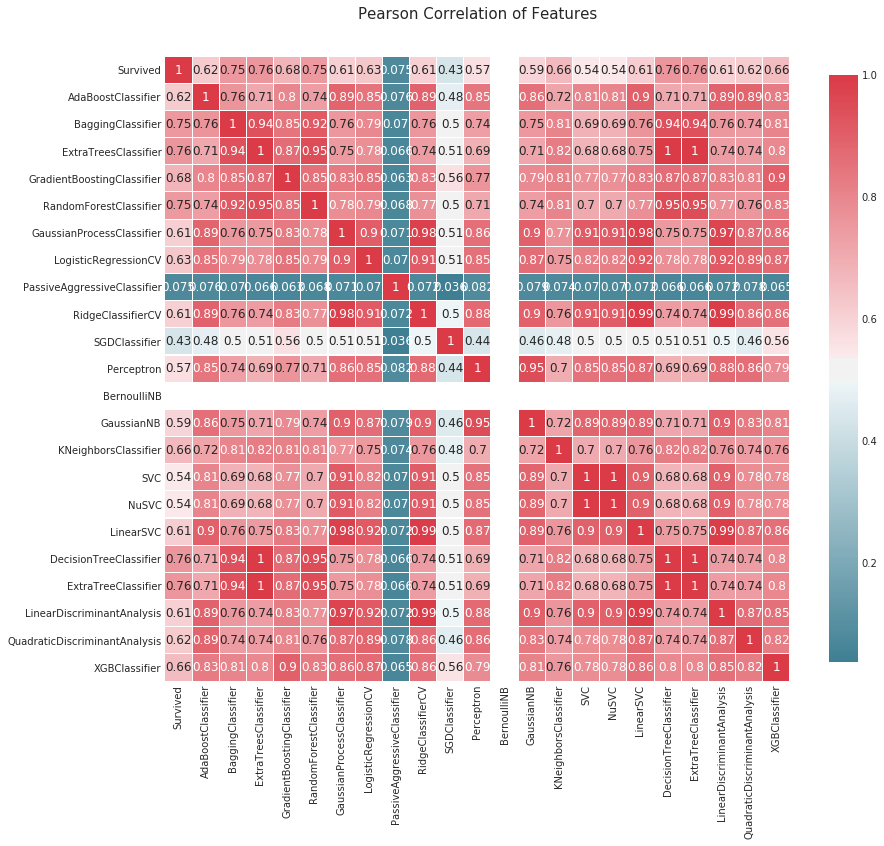

In [81]:
correlation_heatmap(MLA_predict)

In [82]:
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())

]

In [83]:
for est in vote_est:
    print (est[1])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_s

In [84]:
vote_hard = ensemble.VotingClassifier(estimators = vote_est, voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, temp_data[temp_x_bin], temp_data[Target], cv = cv_split)
vote_hard.fit(temp_data[temp_x_bin], temp_data[Target])

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 85.87
Hard Voting Test w/bin score mean: 82.00
Hard Voting Test w/bin score 3*std: +/- 4.90
----------


In [85]:
vote_soft = ensemble.VotingClassifier(estimators= vote_est, voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, temp_data[temp_x_bin], temp_data[Target], cv = cv_split)
vote_soft.fit(temp_data[temp_x_bin], temp_data[Target])

VotingClassifier(estimators=[('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)), ('bc', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimator...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [86]:
print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Soft Voting Training w/bin score mean: 86.85
Soft Voting Test w/bin score mean: 81.78
Soft Voting Test w/bin score 3*std: +/- 6.18
----------


In [87]:
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [0.001, 0.01, 0.05, 0.1, 0.25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .1]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

In [88]:
grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            [{    
            #GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
            }],
        
    
            [{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }],
            
    
            [{
            #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
            'alpha': grid_ratio, #default: 1.0
             }],
    
    
            #GaussianNB - 
            [{}],
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]

In [89]:
start_total = time.perf_counter()

In [90]:
print (start_total)

452059.485066364


In [91]:
print (start_total)

452059.485066364


In [92]:
for clf, param in zip (vote_est, grid_param):
    start = time.perf_counter()
    best_search = model_selection.GridSearchCV(estimator=clf[1], param_grid=param, cv=cv_split, scoring='roc_auc')
    best_search.fit(temp_data[temp_x_bin], temp_data[Target])
    run = time.perf_counter() - start
    
    best_param = best_search.best_params_
    print ('The best parameter for {} is {} with a runtime of {:.2f} seconds!'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param)

run_total = time.perf_counter() - start_total
print ('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print ('--'*10)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 19.43 seconds!
The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 50, 'random_state': 0} with a runtime of 17.44 seconds!
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 50, 'random_state': 0} with a runtime of 36.91 seconds!
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 21.95 seconds!
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 300, 'oob_score': True, 'random_state': 0} with a runtime of 42.75 seconds!
The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 7.26 seconds!
The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'random_stat

In [93]:
grid_hard = ensemble.VotingClassifier(estimators=vote_est, voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, temp_data[temp_x_bin], temp_data[Target],cv = cv_split)
grid_hard.fit(temp_data[temp_x_bin], temp_data[Target])
print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 86.10
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 82.00
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 7.12
----------


In [94]:
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, temp_data[temp_x_bin], temp_data[Target], cv  = cv_split)
grid_soft.fit(temp_data[temp_x_bin], temp_data[Target])

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)

Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 85.62
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 82.44
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 7.42
----------


In [95]:
print (test_data.info())
print ('--'*10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 28 columns):
PassengerId        418 non-null int64
Pclass             418 non-null int64
Name               418 non-null object
Sex                418 non-null object
Age                418 non-null float64
SibSp              418 non-null int64
Parch              418 non-null int64
Ticket             418 non-null object
Fare               418 non-null float64
Cabin              91 non-null object
Embarked           418 non-null object
FamilySize         418 non-null int64
IsAlone            418 non-null int64
Title              418 non-null object
FareBin            418 non-null category
AgeBin             418 non-null category
Sex_Code           418 non-null int64
Embarked_Code      418 non-null int64
Title_Code         418 non-null int64
AgeBin_Code        418 non-null int64
FareBin_Code       418 non-null int64
Title_Target       418 non-null float64
Age_Target         418 non-null float64
Em

In [96]:
test_data['Survived'] = grid_hard.predict(test_data[temp_x_bin])

In [97]:
submit_file = test_data[['PassengerId','Survived']]
submit_file.to_csv("../working/submit_with_target.csv", index=False)

print('Validation Data Distribution: \n', test_data['Survived'].value_counts(normalize = True))
submit_file.sample(10)

Validation Data Distribution: 
 0    0.638756
1    0.361244
Name: Survived, dtype: float64


,PassengerId,Survived
387,1279,0
385,1277,1
236,1128,0
299,1191,0
39,931,0
3,895,0
91,983,0
370,1262,0
103,995,0
193,1085,0
